# Custom Football ELO Rating

The ELO rating system is an alternate way of ranking teams. This rating system works by assigning each team a score and then adding or subtracting points from that score based on the relative skill of the two teams. ELO ratings work well when you are playing a lot games against people with a variety of skill. Chess, is a good example of a game where this rating system works very well. ELO ratings are not so good for team games because the individual members of a team are constantly changing and therefore the current ELO rating may say more about skill of the previous team members as opposed to the current ones.

FIFA uses this rating system to rank international teams, you can read this PDF: https://img.fifa.com/image/upload/edbm045h0udbwkqew35a.pdf for a detailed breakdown for how exactly FIFA's version works. My own version will make some simplifications like not weight matches based on significance. Before implementing this in Python I would like to describe the mathematics behind my ELO rating. (Skip to **implementation** if you just want to see the code).

# Mathematics of the ELO rating system

## Definitions
Let $S^i_j$ denote the score of the $j$th team after the $i$th game. \
Let $R^i_j$ be the result of game $i$ for team $j$ and $E[R^i_{jk}]$ the expected result of the $i$th game of the $j$th team, where the $k$th team are their opponents. \
Let $g^i_j$ denote the number of goals that the $j$th team scored in their $i$th game. \
Let $n$ denote the number of teams in the ELO rating system. \
Let $w^i$ denote the weighting of the $i$th match (based on significance).

**Important Aside** Superscripts in these formulas do not denote powers. They are simply indexes.

## Initial State
Every team starts off with $1000$ points. Or more formally: $\forall j\in\mathbb{Z}_n:S_0^j=1000$. \
As stated in the introduction, the match weightings ($w^i$) are constant in my implementation. \
$R^i_j$ can take on one of three values: $1$ if the team wins, $0.5$ if the team draws and $0$ if the team loses. \
$E[R^i_{jk}]=\frac{1}{1+e^{-\lambda \left(S^i_j-S^i_k\right)}}$. This is a sigmoid function (close to one if $S^i_j>>S^i_k$, $0.5$ if $S^i_j=S^i_k$ and close to zero if $S^i_j<<S^i_k$). $\lambda$ is some positive quantity that weights the difference so the expected value produces sensible scores.

## Main formula
In words, the updated score of a team is their previous score plus the weighted difference between the actual result and the expected result. \
As a formula: $S^{i+1}_j=S^i_j+g^i_j+w^i\left(R^i_j-\frac{1}{1+e^{-\lambda \left(S^i_j-S^i_k\right)}}\right)$

# Implementation

Now we have gone over the mathematics behind the ELO rating system, we will finally start coding.

In [1]:
# Imports

import os # Reading files
import numpy as np # Linear algebra
import pandas as pd # Data processing 
import matplotlib.pyplot as plt # Data visualisation

In [2]:
# Import Data
df = pd.read_csv('../input/international-football-results-from-1872-to-2017/results.csv')

In [3]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [4]:
fix = df[['date', 'home_team', 'away_team', 'home_score', 'away_score']]
fix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42084 entries, 0 to 42083
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        42084 non-null  object
 1   home_team   42084 non-null  object
 2   away_team   42084 non-null  object
 3   home_score  42084 non-null  int64 
 4   away_score  42084 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


## Functions

This calculates the $R^i_j$ and $E[R^i_{jk}]$ value. 

In [5]:
# Expected Score
def score(x, y, r):
    x += 100 * (r - 1 / (1 + np.exp((y - x) / 100))) # Lambda = 0.01
    y += 100 * ((1 - r) - 1 / (1 + np.exp((x - y) / 50))) # Lambda = 0.02
    return [x, y]

# Actual Result
def result(a, b):
    if a > b:
        return 1
    if a == b:
        return 0.5
    if a < b:
        return 0

## Calculating the ELO ratings

In [6]:
# Score Dictionaries
keys = [] # Teams
dict_score = {} # Current ELO score
dict_timeline = {} # History of ELO Scores

# Score Calculator
year_now = 1872 # Starting year
# Loops through every match
for i in range(len(df.date)):
    date = fix.date[i]
    year = date.split('-')[0]
    year = int(year)
    # Checks if the year is different from the current year
    if year != year_now:
        dict_ = dict_score.copy()
        dict_timeline[year_now] = dict_
        year_now = year
    ht = fix.home_team[i]
    at = fix.away_team[i]
    hts = fix.home_score[i]
    ats = fix.away_score[i]
    r = result(hts, ats)
    # If both the home and away teams are new
    if ht not in keys and at not in keys:
        keys.append(ht)
        keys.append(at)
        dict_score[ht] = 1000
        dict_score[at] = 1000
        x = dict_score[ht]
        y = dict_score[at]
        s = score(x, y, r)
        dict_score[ht] = s[0] + hts
        dict_score[at] = s[1] + ats
    # If there are no new teams
    if ht in keys and at in keys:
        x = dict_score[ht]
        y = dict_score[at]
        s = score(x, y, r)
        dict_score[ht] = s[0] + hts
        dict_score[at] = s[1] + ats
    # If only the home team is new
    elif ht not in keys:
        keys.append(ht)
        dict_score[ht] = 1000
        x = dict_score[ht]
        y = dict_score[at]
        s = score(x, y, r)
        dict_score[ht] = s[0] + hts
        dict_score[at] = s[1] + ats
    # If only the away team is new
    elif at not in keys:
        keys.append(at)
        dict_score[at] = 1000
        x = dict_score[ht]
        y = dict_score[at]
        s = score(x, y, r)
        dict_score[ht] = s[0] + hts
        dict_score[at] = s[1] + ats

In [7]:
# Creates a timeline of score the for each country
year = []
dict_ = {}
for country in keys:
    dict_[country] = []
for y in list(dict_timeline.keys()):
    dict = dict_timeline[y]
    year.append(y)
    for country in keys:
        if country in list(dict.keys()):
            dict_[country] += [dict[country]]
        else:
            dict_[country] += [0]

In [8]:
# Shows Each Countries score over time
df_timeline = pd.DataFrame({'country': list(dict_.keys())})
for i in range(len(year)):
    col = []
    y = year[i]
    for country in list(dict_.keys()):
        d = dict_[country]
        col.append(d[i])
    df_timeline[str(y)] = col
    df_timeline[str(y)] = round(df_timeline[str(y)])
df_timeline = df_timeline.sort_values('2019', ascending=False).reset_index(drop='index')

In [9]:
df_timeline.to_csv('mif_timeline.csv',index=False)

In [10]:
# Creates the score_dataframe

def scoretable(year=2019, graph=False):
    y = str(year)
    df_st = df_timeline[['country', y]]
    df_st = df_st.sort_values(y, ascending=False).reset_index(drop='index')
    df_st = df_st[df_st[y] > 0]
    if graph:
        plt.style.use('fivethirtyeight')
        fig, ax = plt.subplots()
        y_pos = np.arange(10)
        ylabel = df_st['country'][:10]
        y_val = df_st[y][:10]
        ax.barh(ylabel, y_val)
        ax.set_xticks(np.arange(round(np.min(y_val),-2)-50,round(np.max(y_val),-2)+20, 20))
        ax.set_xlim([round(np.min(y_val),-2)-50,round(np.max(y_val),-2)+20])
        ax.set_yticks(y_pos)
        ax.set_yticklabels(ylabel)
        ax.invert_yaxis()
        ax.set_xlabel('score')
        ax.set_title('Top 10 Countries')
        plt.show()
    return df_st

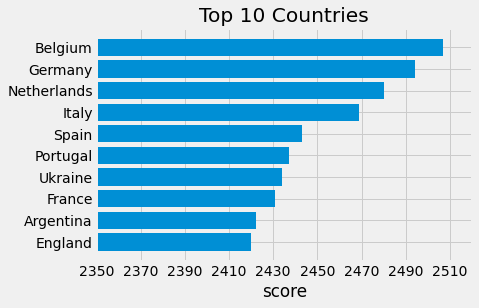

,country,2019
0,Belgium,2507.0
1,Germany,2494.0
2,Netherlands,2480.0
3,Italy,2469.0
4,Spain,2443.0
5,Portugal,2437.0
6,Ukraine,2434.0
7,France,2431.0
8,Argentina,2422.0
9,England,2420.0


In [11]:
scoretable(2019,graph=True).head(10)